# Importanción de librerías 

In [1]:
import tensorflow as tf
import sklearn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import librosa
import os

In [2]:
tf.test.is_gpu_available()

True

# Generación de ficheros

Esta función se encarga de generar un archivo txt de manera que este contenga 2 elementos por fila ('name_file','etiqueta') de esta manera permitirá poder entrenar la red.

In [3]:
import numpy as np
import os
def generate_file_data(dir,name):
    directory=dir
    #el nombre de los archivos posee el primer dígito en el nombre de esta forma permitirá etiquetarlos.
    a={'0':'cero','1':'uno','2':'dos','3':'tres','4':'cuatro','5':'cinco','6':'seis','7':'siete','8':'ocho','9':'nueve'}
    da=os.listdir(directory)
    # ordena los archivos
    da.sort()
    file = open(dir+name+'.txt',"w")
    for filename in da:
        if '.wav' in filename:
            file.write(filename+','+a[filename[0]]+'\n')
    file.close() 
    # genera el fichero
    with open(directory+'/'+name+'.txt') as f:
        read_data = f.read()
        f.closed
    read_data=read_data.split('\n')
    read_data=read_data[0:len(read_data)-1]
    return read_data

# Encoding words with One Hot Encoding
En esta sección se usará one hot encoding para representar las palabras

In [8]:
from sklearn.preprocessing import OneHotEncoder
import sklearn.externals.joblib as joblib
vocabulary_words=np.array(['cero','uno','dos','tres','cuatro','cinco','seis','siete','ocho','nueve'])

In [11]:
if os.path.exists('OneHotEncoding/onehot')==False:
    onehot_encoder = OneHotEncoder(handle_unknown='ignore',categories='auto')
    onehot_encoder.fit(X=vocabulary_words.reshape(-1,1))
    joblib.dump(onehot_encoder,'OneHotEncoding/onehot')
else:
    onehot_encoder=joblib.load('OneHotEncoding/onehot')

In [12]:
onehot_encoder.categories_

[array(['cero', 'cinco', 'cuatro', 'dos', 'nueve', 'ocho', 'seis', 'siete',
        'tres', 'uno'], dtype='<U6')]

In [13]:
v=onehot_encoder.transform(vocabulary_words.reshape(-1,1)).toarray()

In [14]:
v

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]])

In [15]:
onehot_encoder.inverse_transform(v)

array([['cero'],
       ['uno'],
       ['dos'],
       ['tres'],
       ['cuatro'],
       ['cinco'],
       ['seis'],
       ['siete'],
       ['ocho'],
       ['nueve']], dtype='<U6')

### Se muestran las funciones para codificar y decodificar

In [16]:
def encode(x):# tomará un array de string y lo transformada a encode
    return onehot_encoder.transform(x.reshape(-1,1)).toarray()
def decode(x):
    return onehot_encoder.inverse_transform(x)

In [17]:
a=encode(np.array(['uno','dos']))

In [18]:
a

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.]])

In [19]:
decode(a)

array([['uno'],
       ['dos']], dtype='<U6')

# MFCC 


In [20]:
def mfcc_features(DIR,list_dir):
    mfcc_audios=[]
    for dir in list_dir:
        wave, sr = librosa.load(DIR+dir, mono=True)
        features= librosa.feature.mfcc(wave, sr,n_mfcc=13)
        try:
            features=np.pad(features,((0,0),(0,150-len(features[0]))),mode='constant', constant_values=0)
        except OSError as err:
            print(dir)
        mfcc_audios.append(features)
    mfcc_audios=np.array(mfcc_audios)
    return mfcc_audios

In [21]:
def prepare_data(dir,name):
    file = open(dir+name)
    f=file.read()
    file.close()
    f=f.split('\n')
    f=f[0:len(f)-1]
    labels=[]
    names_audios=[]
    for i in f:
        j=i.split(',')
        names_audios.append(j[0])
        labels.append(j[1])
    labels=np.array(labels)
    onehot= encode(labels)
    mfcc=mfcc_features(dir,names_audios)
    print(name+' OK')
    return mfcc,onehot



In [22]:
class dataset:
    def __init__(self,data):
        self.i=0#para el shuffle
        self.data_dir=data
        self.shuffle=None
        self.dir_training=data+'/training/'
        self.dir_test=data+'/test/'
        self.training_set=None
        self.test_set=None
    def split_dataset(self):
        if os.path.exists(self.dir_training+'training.txt')==False:
            generate_file_data(self.dir_training,name='training')
        if os.path.exists(self.dir_training+'test.txt')==False:
            generate_file_data(self.dir_test,name='test')
        print('loadfiles')
    def prepare(self):
        self.training_set=prepare_data(self.dir_training,'training.txt')
        self.test_set=prepare_data(self.dir_test,'test.txt')

    

In [23]:
d=dataset('data')
d.split_dataset()

loadfiles


In [24]:
d.prepare()

training.txt OK
test.txt OK


# Red neuronal 

En esta sección se definen los distintos modelos a aplicar en este seminario

In [25]:
import sklearn
import tensorflow as tf
import time 
import matplotlib.pyplot as plt
import json
import os

In [26]:
# Se dividen los conjuntos
trainX, trainY = d.training_set[0],d.training_set[1]
testX, testY = d.test_set[0],d.test_set[1]
trainX=np.matrix.transpose(trainX,[0,2,1])
testX=np.matrix.transpose(testX,[0,2,1])

##### A continuación mostramos un elemento del training y test

In [27]:
trainX[0]

array([[-5.64680866e+02,  1.31315456e+00,  9.67559702e-01, ...,
         9.03508161e-02,  2.96625196e-01,  4.66707148e-01],
       [-5.29639572e+02,  3.83504027e+01,  1.58076723e+01, ...,
        -5.14833455e+00, -1.47919159e+00,  7.28436449e+00],
       [-5.03711243e+02,  5.91761157e+01,  1.61406856e+01, ...,
        -7.01928874e+00, -5.68180924e+00,  7.32273427e+00],
       ...,
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [28]:
trainX.shape

(240, 150, 13)

## Modelos de prueba
A continuación presentamos 4 modelos que serán entrenados para el reconocimiento de voz.

In [24]:
def RNN_simple(name,n_units=128,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.SimpleRNN(128, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [25]:
def LSTM_simple(name,n_units=128,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [26]:
def LSTM_with_Dropout(name,n_units=128,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400,dropout=0.5):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [34]:
def LSTM_with_2layers(name,n_units=64,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    return history

In [30]:
def LSTM_with_2layers_2D(name,dropout,n_units=64,time_steps=150,n_inputs=13,batch_size=10,n_epochs=400):
    n_class=10
    dir='Models/Model_'
    model=tf.keras.Sequential()
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs),return_sequences=True))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.keras.layers.LSTM(n_units, input_shape=(time_steps,n_inputs)))
    model.add(tf.keras.layers.Dropout(dropout))
    model.add(tf.layers.Dense(n_class, activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    timei=time.time()
    history=model.fit(trainX,trainY,batch_size=batch_size,epochs=n_epochs,validation_data=[testX,testY])
    timef=time.time()
    if os.path.exists(dir+name) == False:
        os.mkdir(dir+name)
    model.save(dir+name+'/'+name)
    t=timef-timei
    file = open(dir+name+'/'+name+'_time.txt',"w")
    file.write(str(t))
    file.close()
    plot_and_saving(history,name)
    return history

## Plotting and saving modelo
Se presentará una función que graficará los resultados y guardará el modelo y sus datos de entrenamiento

In [29]:
def plot_and_saving(history,name):
    dir='Models/Model_'
    # Plot training & validation accuracy values
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('Precision del Modelo')
    plt.ylabel('Precision')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/prec')
    plt.show()
    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Perdida del modelo')
    plt.ylabel('Perdida')
    plt.xlabel('Epoch')
    plt.legend(['Training', 'Test'], loc='upper left')
    plt.savefig(dir+name+'/cost')
    plt.show()
    json.dump(history.history, open('Models/Model_'+name+'/'+name+'_history', 'w'))


# Entrenamientos
Entrenaremos distintas con los modelos definidos y luego se propondrá un modelo que reduzca los problemas de los otros.

## Pruebas

In [46]:
#RNN=RNN_simple('RNNsimple13mfcc',n_units=64)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 2s 10ms/step - loss: 2.3608 - acc: 0.1167 - val_loss: 2.3434 - val_acc: 0.1091
Epoch 2/400
240/240 [==============================] - 2s 6ms/step - loss: 2.3396 - acc: 0.0917 - val_loss: 2.3480 - val_acc: 0.1273
Epoch 3/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3537 - acc: 0.1125 - val_loss: 2.3155 - val_acc: 0.1364
Epoch 4/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3533 - acc: 0.1000 - val_loss: 2.3636 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 2s 7ms/step - loss: 2.3236 - acc: 0.0958 - val_loss: 2.3196 - val_acc: 0.1182
Epoch 6/400
240/240 [==============================] - 2s 8ms/step - loss: 2.2885 - acc: 0.1625 - val_loss: 2.4294 - val_acc: 0.0818
Epoch 7/400
240/240 [==============================] - 2s 8ms/step - loss: 2.3391 - acc: 0.1250 - val_loss: 2.3935 - val_acc: 0.0636
Epoch 8/400
240/240 [=

Epoch 62/400
240/240 [==============================] - 2s 6ms/step - loss: 2.2636 - acc: 0.1583 - val_loss: 2.3976 - val_acc: 0.0636
Epoch 63/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2542 - acc: 0.1750 - val_loss: 2.4040 - val_acc: 0.0909
Epoch 64/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2490 - acc: 0.1625 - val_loss: 2.3880 - val_acc: 0.0727
Epoch 65/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2478 - acc: 0.1583 - val_loss: 2.4143 - val_acc: 0.0727
Epoch 66/400
240/240 [==============================] - 2s 6ms/step - loss: 2.2514 - acc: 0.1708 - val_loss: 2.4165 - val_acc: 0.0545
Epoch 67/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2519 - acc: 0.1792 - val_loss: 2.4091 - val_acc: 0.0455
Epoch 68/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2589 - acc: 0.1500 - val_loss: 2.4070 - val_acc: 0.0545
Epoch 69/400
240/240 [==============================] - 1s 5ms

Epoch 123/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2624 - acc: 0.1708 - val_loss: 2.4238 - val_acc: 0.1091
Epoch 124/400
240/240 [==============================] - 2s 6ms/step - loss: 2.2496 - acc: 0.1667 - val_loss: 2.3987 - val_acc: 0.1000
Epoch 125/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2612 - acc: 0.1917 - val_loss: 2.4176 - val_acc: 0.0636
Epoch 126/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2514 - acc: 0.1833 - val_loss: 2.3914 - val_acc: 0.0636
Epoch 127/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2582 - acc: 0.1750 - val_loss: 2.3978 - val_acc: 0.1273
Epoch 128/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2504 - acc: 0.1667 - val_loss: 2.3984 - val_acc: 0.0727
Epoch 129/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2524 - acc: 0.1792 - val_loss: 2.4041 - val_acc: 0.0727
Epoch 130/400
240/240 [==============================] 

Epoch 244/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2506 - acc: 0.1667 - val_loss: 2.4256 - val_acc: 0.1000
Epoch 245/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2407 - acc: 0.1875 - val_loss: 2.4124 - val_acc: 0.1091
Epoch 246/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2343 - acc: 0.1917 - val_loss: 2.4116 - val_acc: 0.0909
Epoch 247/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2428 - acc: 0.1792 - val_loss: 2.4303 - val_acc: 0.0818
Epoch 248/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2545 - acc: 0.1750 - val_loss: 2.4248 - val_acc: 0.0909
Epoch 249/400
240/240 [==============================] - 1s 6ms/step - loss: 2.3684 - acc: 0.1042 - val_loss: 2.3909 - val_acc: 0.0818
Epoch 250/400
240/240 [==============================] - 2s 6ms/step - loss: 2.3158 - acc: 0.1500 - val_loss: 2.3915 - val_acc: 0.1000
Epoch 251/400
240/240 [==============================] 

Epoch 365/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2504 - acc: 0.1625 - val_loss: 2.3854 - val_acc: 0.1091
Epoch 366/400
240/240 [==============================] - 2s 8ms/step - loss: 2.2462 - acc: 0.1792 - val_loss: 2.3946 - val_acc: 0.0818
Epoch 367/400
240/240 [==============================] - 2s 9ms/step - loss: 2.2415 - acc: 0.1583 - val_loss: 2.3718 - val_acc: 0.1000
Epoch 368/400
240/240 [==============================] - 1s 6ms/step - loss: 2.2450 - acc: 0.1542 - val_loss: 2.3765 - val_acc: 0.1182
Epoch 369/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2453 - acc: 0.1792 - val_loss: 2.3884 - val_acc: 0.0727
Epoch 370/400
240/240 [==============================] - 2s 7ms/step - loss: 2.2478 - acc: 0.1833 - val_loss: 2.3849 - val_acc: 0.1091
Epoch 371/400
240/240 [==============================] - 2s 9ms/step - loss: 2.2408 - acc: 0.1583 - val_loss: 2.3722 - val_acc: 0.1182
Epoch 372/400
240/240 [==============================] 

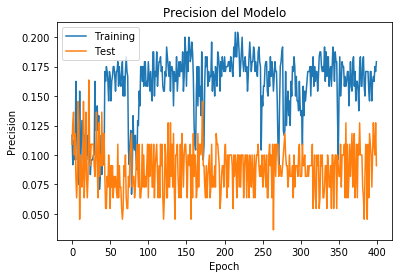

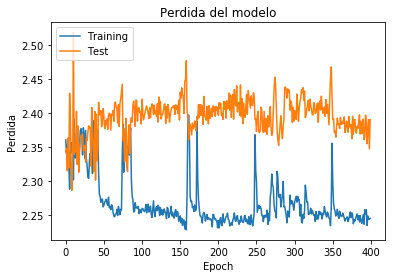

In [47]:
#plot_and_saving(RNN,'RNNsimple13mfcc')

In [33]:
#LSTM=LSTM_simple(name="LSTMSIMPLE",n_epochs=550,n_units=64)

Train on 240 samples, validate on 110 samples
Epoch 1/550
240/240 [==============================] - 7s 31ms/step - loss: 2.3072 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 2/550
240/240 [==============================] - 4s 18ms/step - loss: 2.3009 - acc: 0.0958 - val_loss: 2.3021 - val_acc: 0.0909
Epoch 3/550
240/240 [==============================] - 7s 27ms/step - loss: 2.2899 - acc: 0.1000 - val_loss: 2.3128 - val_acc: 0.1000
Epoch 4/550
240/240 [==============================] - 6s 27ms/step - loss: 2.2856 - acc: 0.1208 - val_loss: 2.2979 - val_acc: 0.1091
Epoch 5/550
240/240 [==============================] - 6s 26ms/step - loss: 2.2770 - acc: 0.1125 - val_loss: 2.2964 - val_acc: 0.1182
Epoch 6/550
240/240 [==============================] - 4s 16ms/step - loss: 2.2752 - acc: 0.1083 - val_loss: 2.3053 - val_acc: 0.1000
Epoch 7/550
240/240 [==============================] - 4s 15ms/step - loss: 2.2715 - acc: 0.1042 - val_loss: 2.2996 - val_acc: 0.1091
Epoch 8/550
240/

240/240 [==============================] - 4s 16ms/step - loss: 0.8761 - acc: 0.6417 - val_loss: 2.0832 - val_acc: 0.3273
Epoch 122/550
240/240 [==============================] - 4s 15ms/step - loss: 0.8839 - acc: 0.6125 - val_loss: 2.3291 - val_acc: 0.2636
Epoch 123/550
240/240 [==============================] - 4s 16ms/step - loss: 0.9888 - acc: 0.5667 - val_loss: 2.2978 - val_acc: 0.3000
Epoch 124/550
240/240 [==============================] - 4s 15ms/step - loss: 1.0492 - acc: 0.5750 - val_loss: 2.0468 - val_acc: 0.3545
Epoch 125/550
240/240 [==============================] - 4s 15ms/step - loss: 1.5684 - acc: 0.4208 - val_loss: 2.5548 - val_acc: 0.2364
Epoch 126/550
240/240 [==============================] - 4s 15ms/step - loss: 1.7458 - acc: 0.3333 - val_loss: 2.3668 - val_acc: 0.3000
Epoch 127/550
240/240 [==============================] - 4s 15ms/step - loss: 1.5894 - acc: 0.3708 - val_loss: 2.0627 - val_acc: 0.3364
Epoch 128/550
240/240 [==============================] - 4s 15

240/240 [==============================] - 4s 15ms/step - loss: 0.5579 - acc: 0.7958 - val_loss: 2.3905 - val_acc: 0.3727
Epoch 242/550
240/240 [==============================] - 4s 15ms/step - loss: 0.6052 - acc: 0.7958 - val_loss: 2.4878 - val_acc: 0.3455
Epoch 243/550
240/240 [==============================] - 4s 15ms/step - loss: 0.5430 - acc: 0.8333 - val_loss: 2.5040 - val_acc: 0.3273
Epoch 244/550
240/240 [==============================] - 4s 16ms/step - loss: 0.4754 - acc: 0.8292 - val_loss: 2.5570 - val_acc: 0.3455
Epoch 245/550
240/240 [==============================] - 4s 15ms/step - loss: 0.3998 - acc: 0.8708 - val_loss: 2.4806 - val_acc: 0.3455
Epoch 246/550
240/240 [==============================] - 4s 15ms/step - loss: 0.3665 - acc: 0.8833 - val_loss: 2.5749 - val_acc: 0.3273
Epoch 247/550
240/240 [==============================] - 4s 15ms/step - loss: 0.3564 - acc: 0.9042 - val_loss: 2.5136 - val_acc: 0.3636
Epoch 248/550
240/240 [==============================] - 4s 15

240/240 [==============================] - 4s 15ms/step - loss: 0.0603 - acc: 0.9917 - val_loss: 2.7938 - val_acc: 0.4273
Epoch 362/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0663 - acc: 0.9875 - val_loss: 2.7522 - val_acc: 0.4455
Epoch 363/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0464 - acc: 0.9958 - val_loss: 2.7925 - val_acc: 0.4364
Epoch 364/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0469 - acc: 0.9958 - val_loss: 2.8160 - val_acc: 0.4455
Epoch 365/550
240/240 [==============================] - 4s 16ms/step - loss: 0.0473 - acc: 0.9917 - val_loss: 2.8863 - val_acc: 0.4455
Epoch 366/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0416 - acc: 0.9917 - val_loss: 2.9024 - val_acc: 0.4455
Epoch 367/550
240/240 [==============================] - 4s 15ms/step - loss: 0.0394 - acc: 0.9917 - val_loss: 2.9116 - val_acc: 0.4455
Epoch 368/550
240/240 [==============================] - 4s 18

240/240 [==============================] - 4s 16ms/step - loss: 0.2610 - acc: 0.9292 - val_loss: 2.2432 - val_acc: 0.4727
Epoch 482/550
240/240 [==============================] - 4s 18ms/step - loss: 0.2353 - acc: 0.9375 - val_loss: 2.2341 - val_acc: 0.4636
Epoch 483/550
240/240 [==============================] - 5s 20ms/step - loss: 0.2201 - acc: 0.9333 - val_loss: 2.2557 - val_acc: 0.4818
Epoch 484/550
240/240 [==============================] - 4s 19ms/step - loss: 0.2250 - acc: 0.9333 - val_loss: 2.3114 - val_acc: 0.4636
Epoch 485/550
240/240 [==============================] - 5s 19ms/step - loss: 0.2196 - acc: 0.9208 - val_loss: 2.4147 - val_acc: 0.4545
Epoch 486/550
240/240 [==============================] - 4s 17ms/step - loss: 0.1996 - acc: 0.9375 - val_loss: 2.4389 - val_acc: 0.4818
Epoch 487/550
240/240 [==============================] - 5s 21ms/step - loss: 0.1869 - acc: 0.9458 - val_loss: 2.4064 - val_acc: 0.5091
Epoch 488/550
240/240 [==============================] - 5s 22

In [34]:
#LSTM_DF64=LSTM_with_Dropout(name='LSTM_dropmfcc64',n_units=64,n_epochs=800,dropout=0.6)

Train on 240 samples, validate on 110 samples
Epoch 1/800
240/240 [==============================] - 5s 19ms/step - loss: 2.3048 - acc: 0.0750 - val_loss: 2.3026 - val_acc: 0.0909
Epoch 2/800
240/240 [==============================] - 4s 15ms/step - loss: 2.3001 - acc: 0.0958 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 3/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2977 - acc: 0.0875 - val_loss: 2.3024 - val_acc: 0.1091
Epoch 4/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2901 - acc: 0.1000 - val_loss: 2.3037 - val_acc: 0.1000
Epoch 5/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2848 - acc: 0.0958 - val_loss: 2.3008 - val_acc: 0.1000
Epoch 6/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2747 - acc: 0.0750 - val_loss: 2.3081 - val_acc: 0.1364
Epoch 7/800
240/240 [==============================] - 4s 15ms/step - loss: 2.2759 - acc: 0.0917 - val_loss: 2.3071 - val_acc: 0.1091
Epoch 8/800
240/

240/240 [==============================] - 4s 17ms/step - loss: 0.7692 - acc: 0.7708 - val_loss: 1.8659 - val_acc: 0.4545
Epoch 122/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7919 - acc: 0.7250 - val_loss: 1.8509 - val_acc: 0.4636
Epoch 123/800
240/240 [==============================] - 4s 16ms/step - loss: 0.7127 - acc: 0.8042 - val_loss: 1.9489 - val_acc: 0.4364
Epoch 124/800
240/240 [==============================] - 4s 18ms/step - loss: 1.0851 - acc: 0.6167 - val_loss: 2.0230 - val_acc: 0.3182
Epoch 125/800
240/240 [==============================] - 4s 17ms/step - loss: 1.2531 - acc: 0.5583 - val_loss: 1.6619 - val_acc: 0.4818
Epoch 126/800
240/240 [==============================] - 4s 17ms/step - loss: 1.1722 - acc: 0.5667 - val_loss: 1.6568 - val_acc: 0.4545
Epoch 127/800
240/240 [==============================] - 4s 16ms/step - loss: 0.9645 - acc: 0.6667 - val_loss: 1.7531 - val_acc: 0.4273
Epoch 128/800
240/240 [==============================] - 4s 19

240/240 [==============================] - 4s 15ms/step - loss: 0.6059 - acc: 0.8083 - val_loss: 2.1925 - val_acc: 0.4000
Epoch 242/800
240/240 [==============================] - 4s 15ms/step - loss: 0.5254 - acc: 0.8167 - val_loss: 2.0924 - val_acc: 0.4273
Epoch 243/800
240/240 [==============================] - 4s 15ms/step - loss: 0.4472 - acc: 0.8458 - val_loss: 2.1764 - val_acc: 0.4000
Epoch 244/800
240/240 [==============================] - 4s 15ms/step - loss: 0.4312 - acc: 0.8542 - val_loss: 2.1634 - val_acc: 0.4182
Epoch 245/800
240/240 [==============================] - 4s 15ms/step - loss: 0.3820 - acc: 0.8708 - val_loss: 2.2534 - val_acc: 0.4091
Epoch 246/800
240/240 [==============================] - 4s 15ms/step - loss: 0.3487 - acc: 0.9042 - val_loss: 2.2445 - val_acc: 0.4000
Epoch 247/800
240/240 [==============================] - 4s 15ms/step - loss: 0.3036 - acc: 0.9125 - val_loss: 2.2740 - val_acc: 0.4273
Epoch 248/800
240/240 [==============================] - 4s 15

KeyboardInterrupt: 

In [74]:
#LSTM_DF128=LSTM_with_Dropout(name='LSTM_dropmfcc128',n_units=128,n_epochs=800,dropout=0.8)

Train on 240 samples, validate on 110 samples
Epoch 1/800
240/240 [==============================] - 6s 27ms/step - loss: 2.3047 - acc: 0.0708 - val_loss: 2.3025 - val_acc: 0.1000
Epoch 2/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2964 - acc: 0.0917 - val_loss: 2.2999 - val_acc: 0.1091
Epoch 3/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2915 - acc: 0.0958 - val_loss: 2.3074 - val_acc: 0.1091
Epoch 4/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2751 - acc: 0.1167 - val_loss: 2.3029 - val_acc: 0.0909
Epoch 5/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2708 - acc: 0.1208 - val_loss: 2.2897 - val_acc: 0.0909
Epoch 6/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2700 - acc: 0.1167 - val_loss: 2.3051 - val_acc: 0.1000
Epoch 7/800
240/240 [==============================] - 4s 17ms/step - loss: 2.2822 - acc: 0.1125 - val_loss: 2.3057 - val_acc: 0.1000
Epoch 8/800
240/

240/240 [==============================] - 4s 17ms/step - loss: 1.5607 - acc: 0.3125 - val_loss: 1.7573 - val_acc: 0.2909
Epoch 122/800
240/240 [==============================] - 4s 17ms/step - loss: 1.3648 - acc: 0.3583 - val_loss: 1.6395 - val_acc: 0.2727
Epoch 123/800
240/240 [==============================] - 4s 17ms/step - loss: 1.3449 - acc: 0.3583 - val_loss: 1.6274 - val_acc: 0.3182
Epoch 124/800
240/240 [==============================] - 4s 17ms/step - loss: 1.4034 - acc: 0.3083 - val_loss: 1.6229 - val_acc: 0.3545
Epoch 125/800
240/240 [==============================] - 4s 18ms/step - loss: 1.3536 - acc: 0.3792 - val_loss: 1.7021 - val_acc: 0.3000
Epoch 126/800
240/240 [==============================] - 4s 17ms/step - loss: 1.4682 - acc: 0.3417 - val_loss: 1.8422 - val_acc: 0.2727
Epoch 127/800
240/240 [==============================] - 4s 17ms/step - loss: 1.4395 - acc: 0.3333 - val_loss: 1.7550 - val_acc: 0.2455
Epoch 128/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.7056 - acc: 0.6792 - val_loss: 1.9672 - val_acc: 0.4636
Epoch 242/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6312 - acc: 0.7083 - val_loss: 1.8630 - val_acc: 0.4545
Epoch 243/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5767 - acc: 0.7167 - val_loss: 1.8317 - val_acc: 0.4364
Epoch 244/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6140 - acc: 0.7083 - val_loss: 1.7333 - val_acc: 0.4818
Epoch 245/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5507 - acc: 0.7208 - val_loss: 1.8108 - val_acc: 0.4545
Epoch 246/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5357 - acc: 0.7167 - val_loss: 1.9569 - val_acc: 0.4455
Epoch 247/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5161 - acc: 0.7500 - val_loss: 1.9326 - val_acc: 0.4545
Epoch 248/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.5276 - acc: 0.7458 - val_loss: 1.3186 - val_acc: 0.5727
Epoch 362/800
240/240 [==============================] - 4s 18ms/step - loss: 0.5664 - acc: 0.7208 - val_loss: 1.3168 - val_acc: 0.5636
Epoch 363/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7280 - acc: 0.6667 - val_loss: 1.4716 - val_acc: 0.5273
Epoch 364/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6685 - acc: 0.7250 - val_loss: 1.2952 - val_acc: 0.5364
Epoch 365/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5649 - acc: 0.7375 - val_loss: 1.4608 - val_acc: 0.5273
Epoch 366/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5318 - acc: 0.7333 - val_loss: 1.4755 - val_acc: 0.5455
Epoch 367/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5138 - acc: 0.7792 - val_loss: 1.4010 - val_acc: 0.5455
Epoch 368/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.4098 - acc: 0.8125 - val_loss: 1.4622 - val_acc: 0.6000
Epoch 482/800
240/240 [==============================] - 4s 17ms/step - loss: 0.4077 - acc: 0.7708 - val_loss: 1.4798 - val_acc: 0.5909
Epoch 483/800
240/240 [==============================] - 4s 17ms/step - loss: 0.4223 - acc: 0.8083 - val_loss: 1.5750 - val_acc: 0.5727
Epoch 484/800
240/240 [==============================] - 4s 17ms/step - loss: 0.4611 - acc: 0.7917 - val_loss: 1.7315 - val_acc: 0.5545
Epoch 485/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5362 - acc: 0.7542 - val_loss: 1.6088 - val_acc: 0.5545
Epoch 486/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5410 - acc: 0.7625 - val_loss: 1.5725 - val_acc: 0.5545
Epoch 487/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6102 - acc: 0.7208 - val_loss: 1.4459 - val_acc: 0.5727
Epoch 488/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.9394 - acc: 0.5875 - val_loss: 1.5987 - val_acc: 0.4818
Epoch 602/800
240/240 [==============================] - 4s 17ms/step - loss: 0.9019 - acc: 0.5917 - val_loss: 1.5272 - val_acc: 0.5000
Epoch 603/800
240/240 [==============================] - 4s 17ms/step - loss: 0.8689 - acc: 0.6167 - val_loss: 1.7589 - val_acc: 0.5000
Epoch 604/800
240/240 [==============================] - 4s 17ms/step - loss: 0.8685 - acc: 0.6250 - val_loss: 1.8078 - val_acc: 0.4727
Epoch 605/800
240/240 [==============================] - 4s 17ms/step - loss: 0.9511 - acc: 0.6000 - val_loss: 2.0172 - val_acc: 0.3545
Epoch 606/800
240/240 [==============================] - 4s 17ms/step - loss: 0.9937 - acc: 0.6000 - val_loss: 1.9520 - val_acc: 0.4000
Epoch 607/800
240/240 [==============================] - 4s 17ms/step - loss: 0.8671 - acc: 0.6042 - val_loss: 1.9604 - val_acc: 0.4273
Epoch 608/800
240/240 [==============================] - 4s 17

240/240 [==============================] - 4s 17ms/step - loss: 0.6192 - acc: 0.7917 - val_loss: 1.6767 - val_acc: 0.5818
Epoch 722/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5867 - acc: 0.8000 - val_loss: 1.7519 - val_acc: 0.5818
Epoch 723/800
240/240 [==============================] - 4s 17ms/step - loss: 0.5425 - acc: 0.8375 - val_loss: 1.7261 - val_acc: 0.5909
Epoch 724/800
240/240 [==============================] - 4s 17ms/step - loss: 0.6937 - acc: 0.7833 - val_loss: 1.7661 - val_acc: 0.5818
Epoch 725/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7778 - acc: 0.7208 - val_loss: 1.9415 - val_acc: 0.5000
Epoch 726/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7945 - acc: 0.7333 - val_loss: 1.6806 - val_acc: 0.5455
Epoch 727/800
240/240 [==============================] - 4s 17ms/step - loss: 0.7661 - acc: 0.7458 - val_loss: 1.7720 - val_acc: 0.5000
Epoch 728/800
240/240 [==============================] - 4s 17

In [75]:
#LSTM128=LSTM_simple(name="LSTMSIMPLE128",n_epochs=200,n_units=128)

Train on 240 samples, validate on 110 samples
Epoch 1/200
240/240 [==============================] - 7s 28ms/step - loss: 2.3054 - acc: 0.0667 - val_loss: 2.3025 - val_acc: 0.0909
Epoch 2/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2943 - acc: 0.0792 - val_loss: 2.3039 - val_acc: 0.0909
Epoch 3/200
240/240 [==============================] - 4s 18ms/step - loss: 2.2869 - acc: 0.0958 - val_loss: 2.3035 - val_acc: 0.1000
Epoch 4/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2787 - acc: 0.1292 - val_loss: 2.3046 - val_acc: 0.1000
Epoch 5/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2743 - acc: 0.1167 - val_loss: 2.3060 - val_acc: 0.1091
Epoch 6/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2785 - acc: 0.1125 - val_loss: 2.3018 - val_acc: 0.1000
Epoch 7/200
240/240 [==============================] - 4s 17ms/step - loss: 2.2673 - acc: 0.1167 - val_loss: 2.3015 - val_acc: 0.1182
Epoch 8/200
240/

240/240 [==============================] - 4s 17ms/step - loss: 0.8557 - acc: 0.6208 - val_loss: 2.0890 - val_acc: 0.4818
Epoch 122/200
240/240 [==============================] - 4s 17ms/step - loss: 0.8360 - acc: 0.6417 - val_loss: 1.9403 - val_acc: 0.4455
Epoch 123/200
240/240 [==============================] - 4s 17ms/step - loss: 0.8635 - acc: 0.6417 - val_loss: 1.9446 - val_acc: 0.4455
Epoch 124/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7730 - acc: 0.6500 - val_loss: 1.9529 - val_acc: 0.4455
Epoch 125/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7268 - acc: 0.7042 - val_loss: 1.9348 - val_acc: 0.4636
Epoch 126/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7640 - acc: 0.7000 - val_loss: 2.0364 - val_acc: 0.4455
Epoch 127/200
240/240 [==============================] - 4s 17ms/step - loss: 0.7378 - acc: 0.6958 - val_loss: 2.0807 - val_acc: 0.4545
Epoch 128/200
240/240 [==============================] - 4s 17

In [76]:
#LSTM256=LSTM_simple(name="LSTMSIMPLE256",n_epochs=200,n_units=256)

Train on 240 samples, validate on 110 samples
Epoch 1/200
240/240 [==============================] - 8s 32ms/step - loss: 2.3071 - acc: 0.0750 - val_loss: 2.3029 - val_acc: 0.0909
Epoch 2/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2906 - acc: 0.1042 - val_loss: 2.3036 - val_acc: 0.0909
Epoch 3/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2913 - acc: 0.0917 - val_loss: 2.3058 - val_acc: 0.1273
Epoch 4/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2664 - acc: 0.1208 - val_loss: 2.2998 - val_acc: 0.1091
Epoch 5/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2865 - acc: 0.0917 - val_loss: 2.3002 - val_acc: 0.1182
Epoch 6/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2038 - acc: 0.1250 - val_loss: 2.0636 - val_acc: 0.1727
Epoch 7/200
240/240 [==============================] - 5s 21ms/step - loss: 2.2486 - acc: 0.1292 - val_loss: 2.1235 - val_acc: 0.1636
Epoch 8/200
240/

240/240 [==============================] - 5s 21ms/step - loss: 1.4150 - acc: 0.4042 - val_loss: 1.7859 - val_acc: 0.3091
Epoch 122/200
240/240 [==============================] - 5s 21ms/step - loss: 1.3717 - acc: 0.3958 - val_loss: 1.8057 - val_acc: 0.3091
Epoch 123/200
240/240 [==============================] - 5s 21ms/step - loss: 1.4421 - acc: 0.3917 - val_loss: 1.7366 - val_acc: 0.3364
Epoch 124/200
240/240 [==============================] - 5s 21ms/step - loss: 1.4140 - acc: 0.3792 - val_loss: 1.7144 - val_acc: 0.3545
Epoch 125/200
240/240 [==============================] - 5s 21ms/step - loss: 1.3675 - acc: 0.3750 - val_loss: 1.7652 - val_acc: 0.3273
Epoch 126/200
240/240 [==============================] - 5s 21ms/step - loss: 1.2964 - acc: 0.4208 - val_loss: 1.7152 - val_acc: 0.3455
Epoch 127/200
240/240 [==============================] - 5s 21ms/step - loss: 1.2872 - acc: 0.4167 - val_loss: 1.7842 - val_acc: 0.3091
Epoch 128/200
240/240 [==============================] - 5s 21

In [50]:
#LSTMD5=LSTM_with_Dropout('LSTM_Dropout5',dropout=0.5,n_units=64)

Train on 240 samples, validate on 110 samples
Epoch 1/400
240/240 [==============================] - 6s 23ms/step - loss: 2.3031 - acc: 0.0750 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 2/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2978 - acc: 0.1167 - val_loss: 2.3032 - val_acc: 0.1000
Epoch 3/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2896 - acc: 0.0958 - val_loss: 2.3061 - val_acc: 0.1000
Epoch 4/400
240/240 [==============================] - 4s 18ms/step - loss: 2.2800 - acc: 0.1167 - val_loss: 2.3112 - val_acc: 0.1000
Epoch 5/400
240/240 [==============================] - 4s 19ms/step - loss: 2.2712 - acc: 0.1333 - val_loss: 2.3072 - val_acc: 0.1091
Epoch 6/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2721 - acc: 0.1292 - val_loss: 2.3049 - val_acc: 0.1182
Epoch 7/400
240/240 [==============================] - 5s 20ms/step - loss: 2.2527 - acc: 0.1375 - val_loss: 2.3025 - val_acc: 0.1091
Epoch 8/400
240/

240/240 [==============================] - 4s 17ms/step - loss: 1.4454 - acc: 0.4125 - val_loss: 1.8892 - val_acc: 0.2364
Epoch 122/400
240/240 [==============================] - 4s 18ms/step - loss: 1.4284 - acc: 0.4042 - val_loss: 1.8699 - val_acc: 0.2636
Epoch 123/400
240/240 [==============================] - 4s 17ms/step - loss: 1.4857 - acc: 0.3458 - val_loss: 1.9084 - val_acc: 0.2273
Epoch 124/400
240/240 [==============================] - 4s 16ms/step - loss: 1.3841 - acc: 0.4292 - val_loss: 1.9087 - val_acc: 0.3000
Epoch 125/400
240/240 [==============================] - 4s 16ms/step - loss: 1.3504 - acc: 0.4250 - val_loss: 1.9952 - val_acc: 0.2636
Epoch 126/400
240/240 [==============================] - 4s 16ms/step - loss: 1.3401 - acc: 0.4458 - val_loss: 1.8307 - val_acc: 0.3091
Epoch 127/400
240/240 [==============================] - 4s 16ms/step - loss: 1.2846 - acc: 0.4333 - val_loss: 1.9937 - val_acc: 0.2364
Epoch 128/400
240/240 [==============================] - 4s 16

240/240 [==============================] - 6s 26ms/step - loss: 1.3494 - acc: 0.4333 - val_loss: 1.7282 - val_acc: 0.3182
Epoch 242/400
240/240 [==============================] - 6s 26ms/step - loss: 1.2355 - acc: 0.4500 - val_loss: 1.6789 - val_acc: 0.3636
Epoch 243/400
240/240 [==============================] - 5s 22ms/step - loss: 1.3354 - acc: 0.4167 - val_loss: 1.6614 - val_acc: 0.3545
Epoch 244/400
240/240 [==============================] - 4s 16ms/step - loss: 1.1528 - acc: 0.5083 - val_loss: 1.7445 - val_acc: 0.3909
Epoch 245/400
240/240 [==============================] - 4s 16ms/step - loss: 1.2642 - acc: 0.4833 - val_loss: 1.8283 - val_acc: 0.3273
Epoch 246/400
240/240 [==============================] - 7s 28ms/step - loss: 1.5073 - acc: 0.3875 - val_loss: 1.7752 - val_acc: 0.2727
Epoch 247/400
240/240 [==============================] - 7s 29ms/step - loss: 1.3115 - acc: 0.4625 - val_loss: 1.7000 - val_acc: 0.3545
Epoch 248/400
240/240 [==============================] - 7s 30

240/240 [==============================] - 4s 18ms/step - loss: 1.0043 - acc: 0.5625 - val_loss: 2.0299 - val_acc: 0.3273
Epoch 362/400
240/240 [==============================] - 4s 15ms/step - loss: 0.8811 - acc: 0.5917 - val_loss: 2.0883 - val_acc: 0.3273
Epoch 363/400
240/240 [==============================] - 4s 15ms/step - loss: 0.8388 - acc: 0.5875 - val_loss: 2.0459 - val_acc: 0.3455
Epoch 364/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7950 - acc: 0.6292 - val_loss: 2.0806 - val_acc: 0.3636
Epoch 365/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7695 - acc: 0.6542 - val_loss: 2.2107 - val_acc: 0.3364
Epoch 366/400
240/240 [==============================] - 4s 15ms/step - loss: 0.7577 - acc: 0.6458 - val_loss: 2.2229 - val_acc: 0.3364
Epoch 367/400
240/240 [==============================] - 5s 21ms/step - loss: 0.7755 - acc: 0.6292 - val_loss: 2.2083 - val_acc: 0.3273
Epoch 368/400
240/240 [==============================] - 4s 17

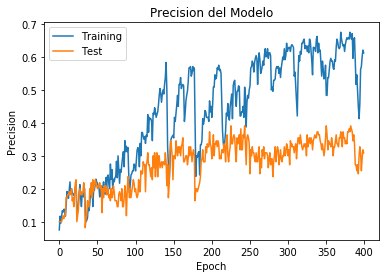

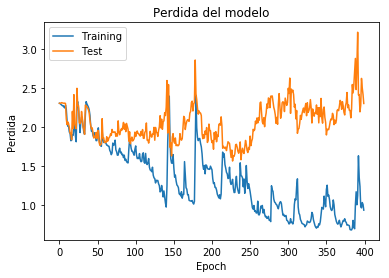

In [51]:
#plot_and_saving(LSTMD5,name='LSTM_Dropout5')

# Propuesta de modelo

Train on 240 samples, validate on 110 samples
Epoch 1/950
240/240 [==============================] - 13s 55ms/step - loss: 2.3010 - acc: 0.0833 - val_loss: 2.3066 - val_acc: 0.1182
Epoch 2/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2945 - acc: 0.1083 - val_loss: 2.3044 - val_acc: 0.1182
Epoch 3/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2927 - acc: 0.0958 - val_loss: 2.3026 - val_acc: 0.1000
Epoch 4/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2884 - acc: 0.0958 - val_loss: 2.3018 - val_acc: 0.1000
Epoch 5/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2773 - acc: 0.1042 - val_loss: 2.3062 - val_acc: 0.1091
Epoch 6/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2860 - acc: 0.1083 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 7/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2802 - acc: 0.1042 - val_loss: 2.3119 - val_acc: 0.0909
Epoch 8/9

Epoch 61/950
240/240 [==============================] - 10s 44ms/step - loss: 2.0786 - acc: 0.2292 - val_loss: 2.1161 - val_acc: 0.2727
Epoch 62/950
240/240 [==============================] - 10s 44ms/step - loss: 1.9254 - acc: 0.2375 - val_loss: 1.8580 - val_acc: 0.2909
Epoch 63/950
240/240 [==============================] - 10s 44ms/step - loss: 1.8233 - acc: 0.2333 - val_loss: 1.9513 - val_acc: 0.2636
Epoch 64/950
240/240 [==============================] - 10s 44ms/step - loss: 1.8270 - acc: 0.2500 - val_loss: 1.9751 - val_acc: 0.1909
Epoch 65/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2190 - acc: 0.1917 - val_loss: 2.2801 - val_acc: 0.1636
Epoch 66/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2141 - acc: 0.1583 - val_loss: 2.1373 - val_acc: 0.2364
Epoch 67/950
240/240 [==============================] - 10s 44ms/step - loss: 2.1189 - acc: 0.1917 - val_loss: 2.0834 - val_acc: 0.2273
Epoch 68/950
240/240 [==========================

240/240 [==============================] - 10s 43ms/step - loss: 1.3182 - acc: 0.5000 - val_loss: 1.5355 - val_acc: 0.4364
Epoch 122/950
240/240 [==============================] - 10s 43ms/step - loss: 1.2971 - acc: 0.4625 - val_loss: 1.4213 - val_acc: 0.4273
Epoch 123/950
240/240 [==============================] - 10s 43ms/step - loss: 1.4193 - acc: 0.4792 - val_loss: 1.5043 - val_acc: 0.4727
Epoch 124/950
240/240 [==============================] - 10s 43ms/step - loss: 1.4361 - acc: 0.4667 - val_loss: 1.7496 - val_acc: 0.3818
Epoch 125/950
240/240 [==============================] - 10s 44ms/step - loss: 1.6838 - acc: 0.3750 - val_loss: 1.6827 - val_acc: 0.4545
Epoch 126/950
240/240 [==============================] - 11s 44ms/step - loss: 1.5276 - acc: 0.4292 - val_loss: 1.7501 - val_acc: 0.3182
Epoch 127/950
240/240 [==============================] - 10s 43ms/step - loss: 1.5814 - acc: 0.3875 - val_loss: 1.5125 - val_acc: 0.3727
Epoch 128/950
240/240 [==============================] 

Epoch 181/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5919 - acc: 0.7750 - val_loss: 0.9719 - val_acc: 0.6909
Epoch 182/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5504 - acc: 0.8042 - val_loss: 1.0561 - val_acc: 0.6091
Epoch 183/950
240/240 [==============================] - 11s 44ms/step - loss: 0.5396 - acc: 0.8083 - val_loss: 1.0978 - val_acc: 0.6455
Epoch 184/950
240/240 [==============================] - 10s 44ms/step - loss: 0.6219 - acc: 0.7500 - val_loss: 1.1446 - val_acc: 0.6818
Epoch 185/950
240/240 [==============================] - 11s 44ms/step - loss: 0.6007 - acc: 0.7750 - val_loss: 1.1730 - val_acc: 0.6364
Epoch 186/950
240/240 [==============================] - 10s 44ms/step - loss: 0.6867 - acc: 0.7125 - val_loss: 1.2321 - val_acc: 0.6273
Epoch 187/950
240/240 [==============================] - 10s 44ms/step - loss: 0.5927 - acc: 0.7625 - val_loss: 1.1607 - val_acc: 0.6364
Epoch 188/950
240/240 [==================

Epoch 241/950
240/240 [==============================] - 11s 44ms/step - loss: 0.4992 - acc: 0.7917 - val_loss: 1.1984 - val_acc: 0.6364
Epoch 242/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4313 - acc: 0.8583 - val_loss: 1.1321 - val_acc: 0.6455
Epoch 243/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3248 - acc: 0.8917 - val_loss: 1.1359 - val_acc: 0.6818
Epoch 244/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3215 - acc: 0.8917 - val_loss: 1.1272 - val_acc: 0.6455
Epoch 245/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3694 - acc: 0.8792 - val_loss: 1.1540 - val_acc: 0.6909
Epoch 246/950
240/240 [==============================] - 10s 44ms/step - loss: 0.2933 - acc: 0.8833 - val_loss: 1.2457 - val_acc: 0.6545
Epoch 247/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3053 - acc: 0.8875 - val_loss: 1.2095 - val_acc: 0.6909
Epoch 248/950
240/240 [==================

Epoch 301/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3287 - acc: 0.8958 - val_loss: 1.3386 - val_acc: 0.6545
Epoch 302/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4071 - acc: 0.8792 - val_loss: 1.2892 - val_acc: 0.6818
Epoch 303/950
240/240 [==============================] - 10s 44ms/step - loss: 0.3305 - acc: 0.8833 - val_loss: 1.3283 - val_acc: 0.6727
Epoch 304/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2140 - acc: 0.9292 - val_loss: 1.3850 - val_acc: 0.6545
Epoch 305/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2426 - acc: 0.9083 - val_loss: 1.2857 - val_acc: 0.6727
Epoch 306/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2728 - acc: 0.8875 - val_loss: 1.2710 - val_acc: 0.7091
Epoch 307/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2175 - acc: 0.9250 - val_loss: 1.2219 - val_acc: 0.7091
Epoch 308/950
240/240 [==================

Epoch 361/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0648 - acc: 0.9750 - val_loss: 1.5354 - val_acc: 0.6909
Epoch 362/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0541 - acc: 0.9833 - val_loss: 1.5365 - val_acc: 0.6727
Epoch 363/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0453 - acc: 0.9875 - val_loss: 1.5694 - val_acc: 0.6636
Epoch 364/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0415 - acc: 0.9875 - val_loss: 1.5078 - val_acc: 0.6818
Epoch 365/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5088 - acc: 0.8375 - val_loss: 1.6335 - val_acc: 0.6273
Epoch 366/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4074 - acc: 0.8458 - val_loss: 1.4888 - val_acc: 0.6636
Epoch 367/950
240/240 [==============================] - 11s 44ms/step - loss: 0.3198 - acc: 0.8875 - val_loss: 1.4813 - val_acc: 0.6636
Epoch 368/950
240/240 [==================

Epoch 421/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0836 - acc: 0.9625 - val_loss: 1.8381 - val_acc: 0.6909
Epoch 422/950
240/240 [==============================] - 11s 44ms/step - loss: 0.0581 - acc: 0.9792 - val_loss: 1.6565 - val_acc: 0.6727
Epoch 423/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1104 - acc: 0.9667 - val_loss: 1.7318 - val_acc: 0.6818
Epoch 424/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0756 - acc: 0.9792 - val_loss: 1.6731 - val_acc: 0.7091
Epoch 425/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0657 - acc: 0.9750 - val_loss: 1.6838 - val_acc: 0.7000
Epoch 426/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0780 - acc: 0.9833 - val_loss: 1.7790 - val_acc: 0.6727
Epoch 427/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0632 - acc: 0.9708 - val_loss: 1.6030 - val_acc: 0.7000
Epoch 428/950
240/240 [==================

Epoch 481/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0632 - acc: 0.9792 - val_loss: 1.5292 - val_acc: 0.6818
Epoch 482/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0253 - acc: 0.9917 - val_loss: 1.5361 - val_acc: 0.6818
Epoch 483/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0251 - acc: 0.9958 - val_loss: 1.5578 - val_acc: 0.6818
Epoch 484/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0237 - acc: 0.9917 - val_loss: 1.5822 - val_acc: 0.6909
Epoch 485/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0340 - acc: 0.9792 - val_loss: 1.5897 - val_acc: 0.7000
Epoch 486/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0284 - acc: 0.9875 - val_loss: 1.6108 - val_acc: 0.7000
Epoch 487/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0339 - acc: 0.9875 - val_loss: 1.6013 - val_acc: 0.7182
Epoch 488/950
240/240 [==================

Epoch 541/950
240/240 [==============================] - 10s 44ms/step - loss: 0.1085 - acc: 0.9667 - val_loss: 1.3974 - val_acc: 0.7000
Epoch 542/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0901 - acc: 0.9792 - val_loss: 1.4395 - val_acc: 0.6727
Epoch 543/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0842 - acc: 0.9708 - val_loss: 1.4879 - val_acc: 0.7091
Epoch 544/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0817 - acc: 0.9792 - val_loss: 1.4833 - val_acc: 0.6818
Epoch 545/950
240/240 [==============================] - 10s 44ms/step - loss: 0.1027 - acc: 0.9667 - val_loss: 1.5285 - val_acc: 0.6818
Epoch 546/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0695 - acc: 0.9708 - val_loss: 1.5413 - val_acc: 0.6909
Epoch 547/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0985 - acc: 0.9667 - val_loss: 1.6752 - val_acc: 0.6545
Epoch 548/950
240/240 [==================

Epoch 601/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0799 - acc: 0.9708 - val_loss: 1.8452 - val_acc: 0.6727
Epoch 602/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4317 - acc: 0.8667 - val_loss: 1.9630 - val_acc: 0.6091
Epoch 603/950
240/240 [==============================] - 10s 44ms/step - loss: 0.4691 - acc: 0.8125 - val_loss: 1.6932 - val_acc: 0.6000
Epoch 604/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5854 - acc: 0.7917 - val_loss: 1.6739 - val_acc: 0.6091
Epoch 605/950
240/240 [==============================] - 11s 45ms/step - loss: 0.4670 - acc: 0.8417 - val_loss: 1.6447 - val_acc: 0.5636
Epoch 606/950
240/240 [==============================] - 10s 44ms/step - loss: 0.6071 - acc: 0.8000 - val_loss: 1.6488 - val_acc: 0.5727
Epoch 607/950
240/240 [==============================] - 10s 44ms/step - loss: 0.4048 - acc: 0.8708 - val_loss: 1.3027 - val_acc: 0.6273
Epoch 608/950
240/240 [==================

Epoch 661/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1572 - acc: 0.9542 - val_loss: 1.6879 - val_acc: 0.6545
Epoch 662/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2153 - acc: 0.9333 - val_loss: 1.5661 - val_acc: 0.6545
Epoch 663/950
240/240 [==============================] - 11s 45ms/step - loss: 0.4088 - acc: 0.8750 - val_loss: 1.6480 - val_acc: 0.6273
Epoch 664/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3970 - acc: 0.8792 - val_loss: 1.5247 - val_acc: 0.6636
Epoch 665/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3498 - acc: 0.8875 - val_loss: 1.4630 - val_acc: 0.6455
Epoch 666/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2162 - acc: 0.9250 - val_loss: 1.3368 - val_acc: 0.6364
Epoch 667/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3180 - acc: 0.9125 - val_loss: 1.2409 - val_acc: 0.6909
Epoch 668/950
240/240 [==================

Epoch 721/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0158 - acc: 0.9917 - val_loss: 1.6546 - val_acc: 0.7182
Epoch 722/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0188 - acc: 0.9875 - val_loss: 1.6592 - val_acc: 0.7091
Epoch 723/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0357 - acc: 0.9875 - val_loss: 1.6113 - val_acc: 0.7091
Epoch 724/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0237 - acc: 0.9875 - val_loss: 1.6546 - val_acc: 0.7091
Epoch 725/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0183 - acc: 0.9917 - val_loss: 1.6288 - val_acc: 0.7000
Epoch 726/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0160 - acc: 0.9958 - val_loss: 1.6374 - val_acc: 0.7091
Epoch 727/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0127 - acc: 0.9958 - val_loss: 1.6585 - val_acc: 0.7182
Epoch 728/950
240/240 [==================

Epoch 781/950
240/240 [==============================] - 10s 44ms/step - loss: 0.2025 - acc: 0.9208 - val_loss: 1.8702 - val_acc: 0.6182
Epoch 782/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5687 - acc: 0.8458 - val_loss: 1.3005 - val_acc: 0.6455
Epoch 783/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3555 - acc: 0.9042 - val_loss: 1.2326 - val_acc: 0.7455
Epoch 784/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2131 - acc: 0.9250 - val_loss: 1.5646 - val_acc: 0.7000
Epoch 785/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2302 - acc: 0.9333 - val_loss: 1.3870 - val_acc: 0.7182
Epoch 786/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1800 - acc: 0.9458 - val_loss: 1.4207 - val_acc: 0.7000
Epoch 787/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1443 - acc: 0.9583 - val_loss: 1.4679 - val_acc: 0.7182
Epoch 788/950
240/240 [==================

Epoch 841/950
240/240 [==============================] - 10s 44ms/step - loss: 0.2946 - acc: 0.8958 - val_loss: 1.1682 - val_acc: 0.6727
Epoch 842/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2271 - acc: 0.9292 - val_loss: 1.2411 - val_acc: 0.6727
Epoch 843/950
240/240 [==============================] - 10s 44ms/step - loss: 0.2402 - acc: 0.9042 - val_loss: 1.1978 - val_acc: 0.6727
Epoch 844/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2208 - acc: 0.9167 - val_loss: 1.1873 - val_acc: 0.6636
Epoch 845/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3740 - acc: 0.8583 - val_loss: 1.1855 - val_acc: 0.6364
Epoch 846/950
240/240 [==============================] - 11s 44ms/step - loss: 0.4103 - acc: 0.8208 - val_loss: 1.4194 - val_acc: 0.6182
Epoch 847/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4184 - acc: 0.8542 - val_loss: 1.3105 - val_acc: 0.6636
Epoch 848/950
240/240 [==================

Epoch 901/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1562 - acc: 0.9500 - val_loss: 1.2003 - val_acc: 0.7182
Epoch 902/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1306 - acc: 0.9542 - val_loss: 1.2005 - val_acc: 0.7273
Epoch 903/950
240/240 [==============================] - 10s 44ms/step - loss: 0.1338 - acc: 0.9542 - val_loss: 1.2988 - val_acc: 0.7182
Epoch 904/950
240/240 [==============================] - 11s 44ms/step - loss: 0.1490 - acc: 0.9458 - val_loss: 1.4883 - val_acc: 0.7273
Epoch 905/950
240/240 [==============================] - 10s 44ms/step - loss: 0.1805 - acc: 0.9500 - val_loss: 1.3749 - val_acc: 0.7091
Epoch 906/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1814 - acc: 0.9583 - val_loss: 1.3438 - val_acc: 0.7091
Epoch 907/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3642 - acc: 0.9167 - val_loss: 1.2788 - val_acc: 0.7273
Epoch 908/950
240/240 [==================

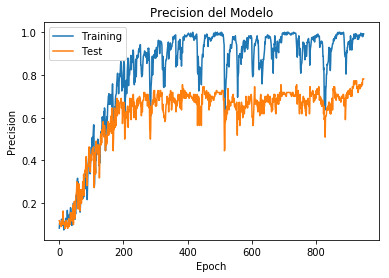

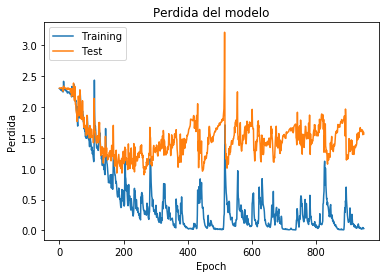

In [35]:
LSTM2L2D950_3=LSTM_with_2layers_2D('LSTM950_3',dropout=0.3,n_units=128,n_epochs=950)


Train on 240 samples, validate on 110 samples
Epoch 1/1000
240/240 [==============================] - 13s 54ms/step - loss: 2.3072 - acc: 0.0792 - val_loss: 2.3034 - val_acc: 0.1000
Epoch 2/1000
240/240 [==============================] - 10s 43ms/step - loss: 2.2944 - acc: 0.0958 - val_loss: 2.3046 - val_acc: 0.0818
Epoch 3/1000
240/240 [==============================] - 10s 43ms/step - loss: 2.2945 - acc: 0.0750 - val_loss: 2.3030 - val_acc: 0.1000
Epoch 4/1000
240/240 [==============================] - 10s 43ms/step - loss: 2.2924 - acc: 0.1000 - val_loss: 2.3039 - val_acc: 0.1000
Epoch 5/1000
240/240 [==============================] - 10s 43ms/step - loss: 2.2900 - acc: 0.0792 - val_loss: 2.3036 - val_acc: 0.1091
Epoch 6/1000
240/240 [==============================] - 10s 42ms/step - loss: 2.2798 - acc: 0.0833 - val_loss: 2.3048 - val_acc: 0.1273
Epoch 7/1000
240/240 [==============================] - 10s 42ms/step - loss: 2.2733 - acc: 0.1458 - val_loss: 2.3127 - val_acc: 0.1000
Ep

Epoch 120/1000
240/240 [==============================] - 10s 42ms/step - loss: 1.0488 - acc: 0.5792 - val_loss: 1.6041 - val_acc: 0.4909
Epoch 121/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.9676 - acc: 0.6500 - val_loss: 1.6612 - val_acc: 0.5091
Epoch 122/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.9346 - acc: 0.6208 - val_loss: 1.6147 - val_acc: 0.5000
Epoch 123/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.8995 - acc: 0.6167 - val_loss: 1.5160 - val_acc: 0.5091
Epoch 124/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.9348 - acc: 0.6292 - val_loss: 1.6058 - val_acc: 0.5273
Epoch 125/1000
240/240 [==============================] - 10s 42ms/step - loss: 1.0028 - acc: 0.5875 - val_loss: 1.4968 - val_acc: 0.5091
Epoch 126/1000
240/240 [==============================] - 10s 42ms/step - loss: 1.1059 - acc: 0.5833 - val_loss: 2.1008 - val_acc: 0.3818
Epoch 127/1000
240/240 [==========

240/240 [==============================] - 10s 42ms/step - loss: 0.8356 - acc: 0.6833 - val_loss: 1.8415 - val_acc: 0.4455
Epoch 239/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.7681 - acc: 0.7208 - val_loss: 1.8130 - val_acc: 0.5091
Epoch 240/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.6468 - acc: 0.7667 - val_loss: 1.8886 - val_acc: 0.4727
Epoch 241/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.6285 - acc: 0.7625 - val_loss: 1.8166 - val_acc: 0.5000
Epoch 242/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.7075 - acc: 0.7208 - val_loss: 1.8815 - val_acc: 0.5000
Epoch 243/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.6597 - acc: 0.7167 - val_loss: 1.9933 - val_acc: 0.5273
Epoch 244/1000
240/240 [==============================] - 10s 43ms/step - loss: 0.6096 - acc: 0.7458 - val_loss: 1.9250 - val_acc: 0.5273
Epoch 245/1000
240/240 [=========================

240/240 [==============================] - 10s 42ms/step - loss: 0.5925 - acc: 0.7792 - val_loss: 1.8786 - val_acc: 0.5545
Epoch 357/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.6174 - acc: 0.7917 - val_loss: 1.6228 - val_acc: 0.5636
Epoch 358/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.5807 - acc: 0.8250 - val_loss: 1.5008 - val_acc: 0.6000
Epoch 359/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.5529 - acc: 0.8083 - val_loss: 1.5016 - val_acc: 0.5818
Epoch 360/1000
240/240 [==============================] - 10s 43ms/step - loss: 0.5560 - acc: 0.8167 - val_loss: 1.4544 - val_acc: 0.6182
Epoch 361/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.4960 - acc: 0.8375 - val_loss: 1.4549 - val_acc: 0.5909
Epoch 362/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.4905 - acc: 0.8375 - val_loss: 1.4709 - val_acc: 0.5909
Epoch 363/1000
240/240 [=========================

240/240 [==============================] - 10s 42ms/step - loss: 0.1693 - acc: 0.9375 - val_loss: 1.6194 - val_acc: 0.6091
Epoch 475/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1504 - acc: 0.9583 - val_loss: 1.7053 - val_acc: 0.6000
Epoch 476/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1666 - acc: 0.9458 - val_loss: 1.7539 - val_acc: 0.5909
Epoch 477/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1296 - acc: 0.9500 - val_loss: 1.6703 - val_acc: 0.6000
Epoch 478/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1434 - acc: 0.9625 - val_loss: 1.6823 - val_acc: 0.6000
Epoch 479/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1577 - acc: 0.9500 - val_loss: 1.8067 - val_acc: 0.6000
Epoch 480/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1591 - acc: 0.9458 - val_loss: 1.8240 - val_acc: 0.5909
Epoch 481/1000
240/240 [=========================

240/240 [==============================] - 10s 42ms/step - loss: 0.0308 - acc: 0.9917 - val_loss: 2.0813 - val_acc: 0.6545
Epoch 593/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0276 - acc: 0.9875 - val_loss: 2.0418 - val_acc: 0.6545
Epoch 594/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0634 - acc: 0.9833 - val_loss: 1.9062 - val_acc: 0.6727
Epoch 595/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0764 - acc: 0.9583 - val_loss: 2.1425 - val_acc: 0.6727
Epoch 596/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0254 - acc: 0.9958 - val_loss: 2.1234 - val_acc: 0.6455
Epoch 597/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1135 - acc: 0.9625 - val_loss: 2.0371 - val_acc: 0.6636
Epoch 598/1000
240/240 [==============================] - 10s 44ms/step - loss: 0.1682 - acc: 0.9458 - val_loss: 2.5292 - val_acc: 0.5909
Epoch 599/1000
240/240 [=========================

240/240 [==============================] - 10s 43ms/step - loss: 0.5924 - acc: 0.7458 - val_loss: 1.2544 - val_acc: 0.6182
Epoch 711/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.5120 - acc: 0.7792 - val_loss: 1.2264 - val_acc: 0.6000
Epoch 712/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.6128 - acc: 0.8125 - val_loss: 1.3030 - val_acc: 0.6000
Epoch 713/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.3712 - acc: 0.8500 - val_loss: 1.4425 - val_acc: 0.6273
Epoch 714/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.3777 - acc: 0.8750 - val_loss: 1.3784 - val_acc: 0.6818
Epoch 715/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.3084 - acc: 0.8750 - val_loss: 1.2717 - val_acc: 0.6455
Epoch 716/1000
240/240 [==============================] - 10s 43ms/step - loss: 0.2699 - acc: 0.9042 - val_loss: 1.2703 - val_acc: 0.6909
Epoch 717/1000
240/240 [=========================

240/240 [==============================] - 10s 42ms/step - loss: 0.1321 - acc: 0.9500 - val_loss: 1.5323 - val_acc: 0.6636
Epoch 829/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.2349 - acc: 0.9500 - val_loss: 1.3324 - val_acc: 0.7000
Epoch 830/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.2145 - acc: 0.9375 - val_loss: 1.5230 - val_acc: 0.6909
Epoch 831/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1791 - acc: 0.9542 - val_loss: 1.4142 - val_acc: 0.7000
Epoch 832/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.1522 - acc: 0.9500 - val_loss: 1.4438 - val_acc: 0.7000
Epoch 833/1000
240/240 [==============================] - 10s 43ms/step - loss: 0.2718 - acc: 0.9208 - val_loss: 1.5510 - val_acc: 0.6727
Epoch 834/1000
240/240 [==============================] - 10s 43ms/step - loss: 0.3927 - acc: 0.8917 - val_loss: 1.1816 - val_acc: 0.7091
Epoch 835/1000
240/240 [=========================

240/240 [==============================] - 10s 42ms/step - loss: 0.0126 - acc: 0.9917 - val_loss: 1.5109 - val_acc: 0.7545
Epoch 947/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0131 - acc: 0.9917 - val_loss: 1.5134 - val_acc: 0.7545
Epoch 948/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0053 - acc: 1.0000 - val_loss: 1.5237 - val_acc: 0.7545
Epoch 949/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0069 - acc: 0.9958 - val_loss: 1.5130 - val_acc: 0.7545
Epoch 950/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0063 - acc: 0.9958 - val_loss: 1.5270 - val_acc: 0.7636
Epoch 951/1000
240/240 [==============================] - 10s 44ms/step - loss: 0.0113 - acc: 0.9917 - val_loss: 1.5335 - val_acc: 0.7545
Epoch 952/1000
240/240 [==============================] - 10s 42ms/step - loss: 0.0064 - acc: 1.0000 - val_loss: 1.5371 - val_acc: 0.7545
Epoch 953/1000
240/240 [=========================

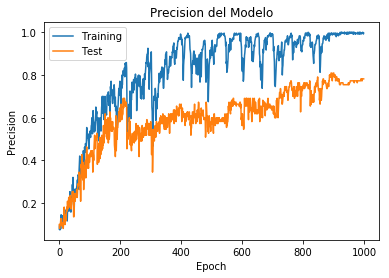

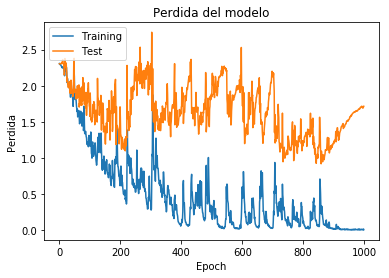

In [36]:
LSTM2L2D1000_3=LSTM_with_2layers_2D('LSTM1000_3',dropout=0.3,n_units=128,n_epochs=1000)

Train on 240 samples, validate on 110 samples
Epoch 1/950
240/240 [==============================] - 14s 57ms/step - loss: 2.3083 - acc: 0.1000 - val_loss: 2.3028 - val_acc: 0.1000
Epoch 2/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2970 - acc: 0.0833 - val_loss: 2.3034 - val_acc: 0.0909
Epoch 3/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2929 - acc: 0.1250 - val_loss: 2.3033 - val_acc: 0.0909
Epoch 4/950
240/240 [==============================] - 10s 43ms/step - loss: 2.2889 - acc: 0.1125 - val_loss: 2.3052 - val_acc: 0.0909
Epoch 5/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2806 - acc: 0.1000 - val_loss: 2.3043 - val_acc: 0.1091
Epoch 6/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2865 - acc: 0.1042 - val_loss: 2.3048 - val_acc: 0.1000
Epoch 7/950
240/240 [==============================] - 10s 44ms/step - loss: 2.2804 - acc: 0.1125 - val_loss: 2.3068 - val_acc: 0.1091
Epoch 8/9

Epoch 61/950
240/240 [==============================] - 10s 43ms/step - loss: 1.9377 - acc: 0.2375 - val_loss: 2.0650 - val_acc: 0.2000
Epoch 62/950
240/240 [==============================] - 10s 43ms/step - loss: 2.0334 - acc: 0.1708 - val_loss: 2.1098 - val_acc: 0.1818
Epoch 63/950
240/240 [==============================] - 10s 43ms/step - loss: 1.9968 - acc: 0.2208 - val_loss: 2.0371 - val_acc: 0.2091
Epoch 64/950
240/240 [==============================] - 10s 43ms/step - loss: 2.0223 - acc: 0.2083 - val_loss: 2.0314 - val_acc: 0.2000
Epoch 65/950
240/240 [==============================] - 10s 43ms/step - loss: 1.9512 - acc: 0.2042 - val_loss: 2.0059 - val_acc: 0.2000
Epoch 66/950
240/240 [==============================] - 11s 44ms/step - loss: 1.9740 - acc: 0.2458 - val_loss: 1.9917 - val_acc: 0.1818
Epoch 67/950
240/240 [==============================] - 11s 44ms/step - loss: 1.8924 - acc: 0.2417 - val_loss: 1.9512 - val_acc: 0.2273
Epoch 68/950
240/240 [==========================

240/240 [==============================] - 10s 43ms/step - loss: 1.7404 - acc: 0.3083 - val_loss: 1.8530 - val_acc: 0.2455
Epoch 122/950
240/240 [==============================] - 10s 43ms/step - loss: 1.5366 - acc: 0.3042 - val_loss: 1.7907 - val_acc: 0.2818
Epoch 123/950
240/240 [==============================] - 10s 43ms/step - loss: 1.4639 - acc: 0.3792 - val_loss: 1.6864 - val_acc: 0.3818
Epoch 124/950
240/240 [==============================] - 11s 44ms/step - loss: 1.4262 - acc: 0.3708 - val_loss: 1.6549 - val_acc: 0.3909
Epoch 125/950
240/240 [==============================] - 10s 43ms/step - loss: 1.4135 - acc: 0.3833 - val_loss: 1.6553 - val_acc: 0.3727
Epoch 126/950
240/240 [==============================] - 10s 43ms/step - loss: 1.4143 - acc: 0.3708 - val_loss: 1.7191 - val_acc: 0.3455
Epoch 127/950
240/240 [==============================] - 10s 43ms/step - loss: 1.5525 - acc: 0.3458 - val_loss: 1.6384 - val_acc: 0.3818
Epoch 128/950
240/240 [==============================] 

Epoch 181/950
240/240 [==============================] - 11s 46ms/step - loss: 1.0382 - acc: 0.5708 - val_loss: 1.5566 - val_acc: 0.4364
Epoch 182/950
240/240 [==============================] - 11s 45ms/step - loss: 1.1477 - acc: 0.4792 - val_loss: 1.7777 - val_acc: 0.4091
Epoch 183/950
240/240 [==============================] - 11s 46ms/step - loss: 1.0960 - acc: 0.5333 - val_loss: 1.7375 - val_acc: 0.3909
Epoch 184/950
240/240 [==============================] - 11s 45ms/step - loss: 1.1607 - acc: 0.5125 - val_loss: 1.7435 - val_acc: 0.3727
Epoch 185/950
240/240 [==============================] - 11s 46ms/step - loss: 1.2815 - acc: 0.4542 - val_loss: 1.7593 - val_acc: 0.3000
Epoch 186/950
240/240 [==============================] - 11s 45ms/step - loss: 1.1461 - acc: 0.4625 - val_loss: 1.6397 - val_acc: 0.3727
Epoch 187/950
240/240 [==============================] - 11s 46ms/step - loss: 1.0508 - acc: 0.5333 - val_loss: 1.6005 - val_acc: 0.4000
Epoch 188/950
240/240 [==================

Epoch 241/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8232 - acc: 0.6042 - val_loss: 1.7682 - val_acc: 0.4091
Epoch 242/950
240/240 [==============================] - 10s 44ms/step - loss: 0.9231 - acc: 0.6083 - val_loss: 1.6711 - val_acc: 0.4273
Epoch 243/950
240/240 [==============================] - 10s 44ms/step - loss: 1.0090 - acc: 0.5917 - val_loss: 1.8166 - val_acc: 0.3818
Epoch 244/950
240/240 [==============================] - 10s 43ms/step - loss: 0.9798 - acc: 0.5917 - val_loss: 1.7094 - val_acc: 0.4182
Epoch 245/950
240/240 [==============================] - 10s 43ms/step - loss: 0.9368 - acc: 0.6042 - val_loss: 1.5491 - val_acc: 0.4636
Epoch 246/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8519 - acc: 0.6125 - val_loss: 1.4106 - val_acc: 0.4636
Epoch 247/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8974 - acc: 0.6000 - val_loss: 1.4971 - val_acc: 0.5000
Epoch 248/950
240/240 [==================

Epoch 301/950
240/240 [==============================] - 10s 43ms/step - loss: 0.7155 - acc: 0.6667 - val_loss: 1.6515 - val_acc: 0.5273
Epoch 302/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6575 - acc: 0.7083 - val_loss: 1.6764 - val_acc: 0.5182
Epoch 303/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6675 - acc: 0.6875 - val_loss: 1.6308 - val_acc: 0.4818
Epoch 304/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6519 - acc: 0.6792 - val_loss: 1.7147 - val_acc: 0.5182
Epoch 305/950
240/240 [==============================] - 11s 44ms/step - loss: 0.5999 - acc: 0.7333 - val_loss: 1.7780 - val_acc: 0.5091
Epoch 306/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6369 - acc: 0.7000 - val_loss: 1.8027 - val_acc: 0.5000
Epoch 307/950
240/240 [==============================] - 10s 44ms/step - loss: 0.5981 - acc: 0.7125 - val_loss: 1.7566 - val_acc: 0.5364
Epoch 308/950
240/240 [==================

Epoch 361/950
240/240 [==============================] - 10s 43ms/step - loss: 1.2540 - acc: 0.4667 - val_loss: 1.5983 - val_acc: 0.3636
Epoch 362/950
240/240 [==============================] - 11s 44ms/step - loss: 1.2325 - acc: 0.4667 - val_loss: 1.6500 - val_acc: 0.3182
Epoch 363/950
240/240 [==============================] - 10s 44ms/step - loss: 1.2479 - acc: 0.4500 - val_loss: 1.6832 - val_acc: 0.3182
Epoch 364/950
240/240 [==============================] - 10s 44ms/step - loss: 1.1836 - acc: 0.4708 - val_loss: 1.7136 - val_acc: 0.2636
Epoch 365/950
240/240 [==============================] - 10s 44ms/step - loss: 1.3090 - acc: 0.4333 - val_loss: 1.6521 - val_acc: 0.3545
Epoch 366/950
240/240 [==============================] - 10s 44ms/step - loss: 1.2318 - acc: 0.4583 - val_loss: 1.6633 - val_acc: 0.2909
Epoch 367/950
240/240 [==============================] - 10s 43ms/step - loss: 1.2020 - acc: 0.4833 - val_loss: 1.6229 - val_acc: 0.4000
Epoch 368/950
240/240 [==================

Epoch 421/950
240/240 [==============================] - 10s 44ms/step - loss: 0.9038 - acc: 0.6042 - val_loss: 1.7664 - val_acc: 0.3273
Epoch 422/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8337 - acc: 0.6583 - val_loss: 1.7816 - val_acc: 0.3455
Epoch 423/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8621 - acc: 0.6250 - val_loss: 1.8482 - val_acc: 0.3000
Epoch 424/950
240/240 [==============================] - 10s 44ms/step - loss: 0.9050 - acc: 0.5792 - val_loss: 1.9355 - val_acc: 0.3182
Epoch 425/950
240/240 [==============================] - 11s 44ms/step - loss: 0.9111 - acc: 0.5917 - val_loss: 2.0568 - val_acc: 0.3636
Epoch 426/950
240/240 [==============================] - 10s 44ms/step - loss: 1.0207 - acc: 0.5917 - val_loss: 2.0228 - val_acc: 0.2818
Epoch 427/950
240/240 [==============================] - 10s 43ms/step - loss: 0.9780 - acc: 0.5917 - val_loss: 1.7555 - val_acc: 0.4000
Epoch 428/950
240/240 [==================

Epoch 481/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8529 - acc: 0.6542 - val_loss: 1.6636 - val_acc: 0.4273
Epoch 482/950
240/240 [==============================] - 10s 43ms/step - loss: 0.7490 - acc: 0.7292 - val_loss: 1.7186 - val_acc: 0.4091
Epoch 483/950
240/240 [==============================] - 11s 44ms/step - loss: 0.6886 - acc: 0.7458 - val_loss: 1.6833 - val_acc: 0.4273
Epoch 484/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6919 - acc: 0.7292 - val_loss: 1.8533 - val_acc: 0.4182
Epoch 485/950
240/240 [==============================] - 10s 44ms/step - loss: 0.7186 - acc: 0.7375 - val_loss: 1.8158 - val_acc: 0.4273
Epoch 486/950
240/240 [==============================] - 11s 45ms/step - loss: 0.7220 - acc: 0.7208 - val_loss: 1.8107 - val_acc: 0.4000
Epoch 487/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6498 - acc: 0.7250 - val_loss: 1.6627 - val_acc: 0.3818
Epoch 488/950
240/240 [==================

Epoch 541/950
240/240 [==============================] - 10s 43ms/step - loss: 0.8911 - acc: 0.6708 - val_loss: 1.9980 - val_acc: 0.3909
Epoch 542/950
240/240 [==============================] - 10s 43ms/step - loss: 1.2682 - acc: 0.5750 - val_loss: 2.0256 - val_acc: 0.3909
Epoch 543/950
240/240 [==============================] - 10s 43ms/step - loss: 1.2147 - acc: 0.5167 - val_loss: 1.6325 - val_acc: 0.3909
Epoch 544/950
240/240 [==============================] - 10s 43ms/step - loss: 1.0636 - acc: 0.5833 - val_loss: 1.7137 - val_acc: 0.4273
Epoch 545/950
240/240 [==============================] - 10s 43ms/step - loss: 0.9931 - acc: 0.6458 - val_loss: 1.7710 - val_acc: 0.3909
Epoch 546/950
240/240 [==============================] - 11s 44ms/step - loss: 0.8561 - acc: 0.6625 - val_loss: 1.6489 - val_acc: 0.3909
Epoch 547/950
240/240 [==============================] - 10s 43ms/step - loss: 0.9414 - acc: 0.6083 - val_loss: 1.7344 - val_acc: 0.3909
Epoch 548/950
240/240 [==================

Epoch 601/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3462 - acc: 0.8958 - val_loss: 2.0485 - val_acc: 0.4909
Epoch 602/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2859 - acc: 0.8792 - val_loss: 2.2061 - val_acc: 0.4545
Epoch 603/950
240/240 [==============================] - 11s 45ms/step - loss: 0.2670 - acc: 0.8917 - val_loss: 2.0195 - val_acc: 0.4909
Epoch 604/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2733 - acc: 0.8875 - val_loss: 2.0311 - val_acc: 0.4909
Epoch 605/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3324 - acc: 0.8833 - val_loss: 1.9595 - val_acc: 0.4818
Epoch 606/950
240/240 [==============================] - 10s 44ms/step - loss: 0.3966 - acc: 0.8500 - val_loss: 2.1516 - val_acc: 0.4909
Epoch 607/950
240/240 [==============================] - 10s 44ms/step - loss: 0.6559 - acc: 0.7500 - val_loss: 1.9674 - val_acc: 0.4545
Epoch 608/950
240/240 [==================

Epoch 661/950
240/240 [==============================] - 11s 44ms/step - loss: 0.5940 - acc: 0.7667 - val_loss: 1.7102 - val_acc: 0.4909
Epoch 662/950
240/240 [==============================] - 10s 44ms/step - loss: 0.5806 - acc: 0.7708 - val_loss: 1.7302 - val_acc: 0.4455
Epoch 663/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6482 - acc: 0.7292 - val_loss: 1.8287 - val_acc: 0.4909
Epoch 664/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6528 - acc: 0.7333 - val_loss: 1.6947 - val_acc: 0.4909
Epoch 665/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6099 - acc: 0.7417 - val_loss: 1.7590 - val_acc: 0.4818
Epoch 666/950
240/240 [==============================] - 10s 44ms/step - loss: 0.5904 - acc: 0.7750 - val_loss: 2.1091 - val_acc: 0.4182
Epoch 667/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6627 - acc: 0.7625 - val_loss: 2.1128 - val_acc: 0.3636
Epoch 668/950
240/240 [==================

Epoch 721/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4665 - acc: 0.8458 - val_loss: 1.9212 - val_acc: 0.5636
Epoch 722/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5495 - acc: 0.8250 - val_loss: 2.0420 - val_acc: 0.4909
Epoch 723/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4578 - acc: 0.8208 - val_loss: 2.1081 - val_acc: 0.4818
Epoch 724/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3843 - acc: 0.8833 - val_loss: 2.0275 - val_acc: 0.5182
Epoch 725/950
240/240 [==============================] - 10s 44ms/step - loss: 0.3088 - acc: 0.9083 - val_loss: 2.1144 - val_acc: 0.5091
Epoch 726/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3111 - acc: 0.8875 - val_loss: 2.1548 - val_acc: 0.4727
Epoch 727/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3202 - acc: 0.8917 - val_loss: 2.1922 - val_acc: 0.5000
Epoch 728/950
240/240 [==================

Epoch 781/950
240/240 [==============================] - 10s 44ms/step - loss: 0.3736 - acc: 0.8792 - val_loss: 2.0167 - val_acc: 0.5182
Epoch 782/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3450 - acc: 0.8792 - val_loss: 1.8947 - val_acc: 0.5818
Epoch 783/950
240/240 [==============================] - 10s 44ms/step - loss: 0.3330 - acc: 0.8708 - val_loss: 2.1038 - val_acc: 0.5636
Epoch 784/950
240/240 [==============================] - 10s 44ms/step - loss: 0.3549 - acc: 0.8917 - val_loss: 2.0324 - val_acc: 0.5273
Epoch 785/950
240/240 [==============================] - 11s 46ms/step - loss: 0.3489 - acc: 0.8708 - val_loss: 2.0628 - val_acc: 0.5455
Epoch 786/950
240/240 [==============================] - 12s 48ms/step - loss: 0.2619 - acc: 0.9083 - val_loss: 2.0034 - val_acc: 0.5455
Epoch 787/950
240/240 [==============================] - 11s 46ms/step - loss: 0.2685 - acc: 0.9458 - val_loss: 2.2473 - val_acc: 0.5364
Epoch 788/950
240/240 [==================

Epoch 841/950
240/240 [==============================] - 10s 43ms/step - loss: 0.0759 - acc: 0.9792 - val_loss: 2.0101 - val_acc: 0.5273
Epoch 842/950
240/240 [==============================] - 11s 44ms/step - loss: 0.0618 - acc: 0.9875 - val_loss: 2.1881 - val_acc: 0.5091
Epoch 843/950
240/240 [==============================] - 11s 45ms/step - loss: 0.0764 - acc: 0.9833 - val_loss: 1.9952 - val_acc: 0.5636
Epoch 844/950
240/240 [==============================] - 10s 43ms/step - loss: 0.2228 - acc: 0.9333 - val_loss: 2.1199 - val_acc: 0.5636
Epoch 845/950
240/240 [==============================] - 10s 44ms/step - loss: 0.0995 - acc: 0.9708 - val_loss: 2.0664 - val_acc: 0.5636
Epoch 846/950
240/240 [==============================] - 10s 43ms/step - loss: 0.1812 - acc: 0.9292 - val_loss: 2.2696 - val_acc: 0.5091
Epoch 847/950
240/240 [==============================] - 10s 44ms/step - loss: 0.2213 - acc: 0.9375 - val_loss: 1.9972 - val_acc: 0.5182
Epoch 848/950
240/240 [==================

Epoch 901/950
240/240 [==============================] - 11s 44ms/step - loss: 0.3697 - acc: 0.8875 - val_loss: 2.1185 - val_acc: 0.4909
Epoch 902/950
240/240 [==============================] - 10s 44ms/step - loss: 0.4660 - acc: 0.8208 - val_loss: 2.2205 - val_acc: 0.4909
Epoch 903/950
240/240 [==============================] - 10s 43ms/step - loss: 0.6764 - acc: 0.8042 - val_loss: 1.8214 - val_acc: 0.5000
Epoch 904/950
240/240 [==============================] - 10s 43ms/step - loss: 0.4443 - acc: 0.8458 - val_loss: 1.9454 - val_acc: 0.5091
Epoch 905/950
240/240 [==============================] - 10s 43ms/step - loss: 0.5487 - acc: 0.8083 - val_loss: 1.8321 - val_acc: 0.5273
Epoch 906/950
240/240 [==============================] - 10s 44ms/step - loss: 0.4365 - acc: 0.8583 - val_loss: 1.7431 - val_acc: 0.5545
Epoch 907/950
240/240 [==============================] - 10s 43ms/step - loss: 0.3915 - acc: 0.8583 - val_loss: 1.7130 - val_acc: 0.5455
Epoch 908/950
240/240 [==================

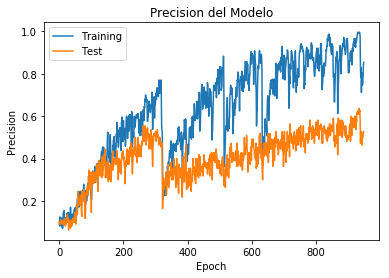

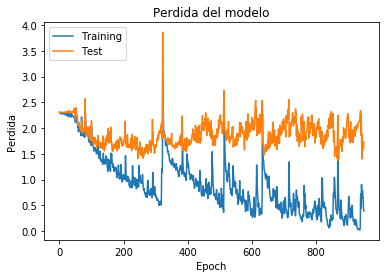

In [37]:
LSTM2L2D950_4=LSTM_with_2layers_2D('LSTM950_4',dropout=0.4,n_units=128,n_epochs=950)

# FIN


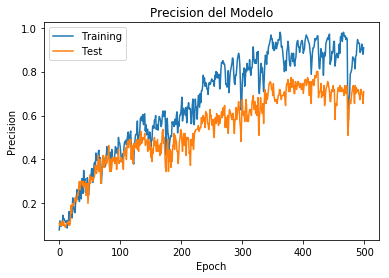

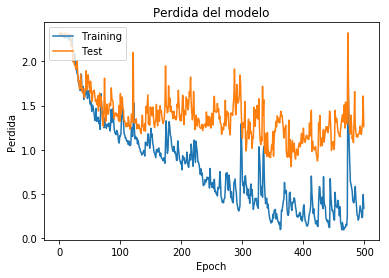

In [45]:
plt.plot(LSTM2L2D600_4.history['acc'][0:500])
plt.plot(LSTM2L2D600_4.history['val_acc'][0:500])
plt.title('Precision del Modelo')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.savefig('prec500')
plt.show()
# Plot training & validation loss values
plt.plot(LSTM2L2D600_4.history['loss'][0:500])
plt.plot(LSTM2L2D600_4.history['val_loss'][0:500])
plt.title('Perdida del modelo')
plt.ylabel('Perdida')
plt.xlabel('Epoch')
plt.legend(['Training', 'Test'], loc='upper left')
plt.savefig('cost500')
plt.show()

In [39]:
LSTM2L2D600_6=LSTM_with_2layers_2D('LSTM600_6',dropout=0.6,n_units=64,n_epochs=600)

Train on 240 samples, validate on 110 samples
Epoch 1/600
240/240 [==============================] - 23s 96ms/step - loss: 2.3046 - acc: 0.0708 - val_loss: 2.3027 - val_acc: 0.1000
Epoch 2/600
240/240 [==============================] - 14s 58ms/step - loss: 2.3001 - acc: 0.1042 - val_loss: 2.3034 - val_acc: 0.1091
Epoch 3/600
240/240 [==============================] - 13s 55ms/step - loss: 2.2909 - acc: 0.0917 - val_loss: 2.3080 - val_acc: 0.1182
Epoch 4/600
240/240 [==============================] - 12s 48ms/step - loss: 2.2860 - acc: 0.1083 - val_loss: 2.3037 - val_acc: 0.1000
Epoch 5/600
240/240 [==============================] - 12s 49ms/step - loss: 2.2950 - acc: 0.0958 - val_loss: 2.3038 - val_acc: 0.1000
Epoch 6/600
240/240 [==============================] - 12s 49ms/step - loss: 2.2907 - acc: 0.1000 - val_loss: 2.3027 - val_acc: 0.0909
Epoch 7/600
240/240 [==============================] - 12s 52ms/step - loss: 2.2765 - acc: 0.1125 - val_loss: 2.3142 - val_acc: 0.0818
Epoch 8/6

Epoch 61/600
240/240 [==============================] - 12s 50ms/step - loss: 2.0004 - acc: 0.2042 - val_loss: 2.0308 - val_acc: 0.1636
Epoch 62/600
240/240 [==============================] - 12s 50ms/step - loss: 2.0449 - acc: 0.1875 - val_loss: 2.0520 - val_acc: 0.1545
Epoch 63/600
240/240 [==============================] - 15s 62ms/step - loss: 2.0393 - acc: 0.1833 - val_loss: 2.0317 - val_acc: 0.1818
Epoch 64/600
240/240 [==============================] - 13s 53ms/step - loss: 1.9861 - acc: 0.2125 - val_loss: 1.9930 - val_acc: 0.2091
Epoch 65/600
240/240 [==============================] - 12s 52ms/step - loss: 1.9316 - acc: 0.2208 - val_loss: 1.9877 - val_acc: 0.2000
Epoch 66/600
240/240 [==============================] - 13s 53ms/step - loss: 1.9323 - acc: 0.2292 - val_loss: 1.9905 - val_acc: 0.1818
Epoch 67/600
240/240 [==============================] - 16s 66ms/step - loss: 1.9128 - acc: 0.1583 - val_loss: 1.9440 - val_acc: 0.1909
Epoch 68/600
240/240 [==========================

240/240 [==============================] - 10s 43ms/step - loss: 1.8586 - acc: 0.2292 - val_loss: 1.9584 - val_acc: 0.2091
Epoch 122/600
240/240 [==============================] - 10s 43ms/step - loss: 1.8503 - acc: 0.2000 - val_loss: 1.9585 - val_acc: 0.2091
Epoch 123/600
240/240 [==============================] - 10s 43ms/step - loss: 1.8481 - acc: 0.2167 - val_loss: 1.9538 - val_acc: 0.2273
Epoch 124/600
240/240 [==============================] - 10s 43ms/step - loss: 1.8341 - acc: 0.2250 - val_loss: 1.9506 - val_acc: 0.2273
Epoch 125/600
240/240 [==============================] - 11s 44ms/step - loss: 1.8567 - acc: 0.1917 - val_loss: 1.9602 - val_acc: 0.2182
Epoch 126/600
240/240 [==============================] - 13s 53ms/step - loss: 1.8995 - acc: 0.2333 - val_loss: 1.9414 - val_acc: 0.2091
Epoch 127/600
240/240 [==============================] - 11s 44ms/step - loss: 1.8789 - acc: 0.2458 - val_loss: 1.9360 - val_acc: 0.2000
Epoch 128/600
240/240 [==============================] 

Epoch 181/600
240/240 [==============================] - 12s 50ms/step - loss: 1.7372 - acc: 0.2958 - val_loss: 1.7725 - val_acc: 0.2636
Epoch 182/600
240/240 [==============================] - 11s 46ms/step - loss: 1.5891 - acc: 0.3125 - val_loss: 1.8028 - val_acc: 0.2636
Epoch 183/600
240/240 [==============================] - 12s 50ms/step - loss: 1.6093 - acc: 0.2583 - val_loss: 1.7149 - val_acc: 0.3727
Epoch 184/600
240/240 [==============================] - 13s 53ms/step - loss: 1.5267 - acc: 0.3667 - val_loss: 1.6897 - val_acc: 0.3182
Epoch 185/600
240/240 [==============================] - 12s 49ms/step - loss: 1.5031 - acc: 0.3375 - val_loss: 1.6107 - val_acc: 0.3818
Epoch 186/600
240/240 [==============================] - 12s 49ms/step - loss: 1.4015 - acc: 0.3750 - val_loss: 1.6660 - val_acc: 0.3727
Epoch 187/600
240/240 [==============================] - 13s 54ms/step - loss: 1.3742 - acc: 0.3958 - val_loss: 1.5934 - val_acc: 0.3545
Epoch 188/600
240/240 [==================

Epoch 241/600
240/240 [==============================] - 13s 53ms/step - loss: 1.7598 - acc: 0.2583 - val_loss: 2.0341 - val_acc: 0.2000
Epoch 242/600
240/240 [==============================] - 14s 58ms/step - loss: 1.6986 - acc: 0.3125 - val_loss: 2.0161 - val_acc: 0.2364
Epoch 243/600
240/240 [==============================] - 13s 52ms/step - loss: 1.6945 - acc: 0.3083 - val_loss: 2.0677 - val_acc: 0.2909
Epoch 244/600
240/240 [==============================] - 14s 58ms/step - loss: 1.8559 - acc: 0.2708 - val_loss: 1.9612 - val_acc: 0.2636
Epoch 245/600
240/240 [==============================] - 11s 47ms/step - loss: 1.7656 - acc: 0.2250 - val_loss: 1.9022 - val_acc: 0.2909
Epoch 246/600
240/240 [==============================] - 15s 63ms/step - loss: 1.7096 - acc: 0.3167 - val_loss: 1.8920 - val_acc: 0.2545
Epoch 247/600
240/240 [==============================] - 14s 57ms/step - loss: 1.6576 - acc: 0.3292 - val_loss: 1.9381 - val_acc: 0.2909
Epoch 248/600
240/240 [==================

Epoch 301/600
240/240 [==============================] - 13s 55ms/step - loss: 1.1698 - acc: 0.5333 - val_loss: 1.4584 - val_acc: 0.4909
Epoch 302/600
240/240 [==============================] - 12s 49ms/step - loss: 1.2673 - acc: 0.4708 - val_loss: 1.4895 - val_acc: 0.4818
Epoch 303/600
240/240 [==============================] - 11s 47ms/step - loss: 1.1914 - acc: 0.4792 - val_loss: 1.4423 - val_acc: 0.4909
Epoch 304/600
240/240 [==============================] - 12s 49ms/step - loss: 1.1791 - acc: 0.5125 - val_loss: 1.4642 - val_acc: 0.4545
Epoch 305/600
240/240 [==============================] - 15s 62ms/step - loss: 1.1408 - acc: 0.5292 - val_loss: 1.4165 - val_acc: 0.5091
Epoch 306/600
240/240 [==============================] - 15s 62ms/step - loss: 1.1650 - acc: 0.5208 - val_loss: 1.3685 - val_acc: 0.4909
Epoch 307/600
240/240 [==============================] - 13s 52ms/step - loss: 1.1173 - acc: 0.5208 - val_loss: 1.3864 - val_acc: 0.4636
Epoch 308/600
240/240 [==================

Epoch 361/600
240/240 [==============================] - 13s 54ms/step - loss: 0.9577 - acc: 0.6375 - val_loss: 1.2795 - val_acc: 0.5273
Epoch 362/600
240/240 [==============================] - 12s 50ms/step - loss: 0.9729 - acc: 0.6125 - val_loss: 1.4205 - val_acc: 0.5273
Epoch 363/600
240/240 [==============================] - 13s 55ms/step - loss: 0.8286 - acc: 0.6667 - val_loss: 1.3939 - val_acc: 0.5273
Epoch 364/600
240/240 [==============================] - 11s 47ms/step - loss: 0.7924 - acc: 0.6458 - val_loss: 1.3742 - val_acc: 0.5727
Epoch 365/600
240/240 [==============================] - 11s 45ms/step - loss: 0.7591 - acc: 0.7125 - val_loss: 1.3713 - val_acc: 0.5545
Epoch 366/600
240/240 [==============================] - 11s 48ms/step - loss: 0.7924 - acc: 0.7167 - val_loss: 1.3870 - val_acc: 0.5545
Epoch 367/600
240/240 [==============================] - 12s 52ms/step - loss: 0.7939 - acc: 0.6667 - val_loss: 1.4910 - val_acc: 0.5364
Epoch 368/600
240/240 [==================

Epoch 421/600
240/240 [==============================] - 18s 73ms/step - loss: 0.6526 - acc: 0.7250 - val_loss: 1.1511 - val_acc: 0.6000
Epoch 422/600
240/240 [==============================] - 17s 72ms/step - loss: 0.5640 - acc: 0.7833 - val_loss: 0.9984 - val_acc: 0.6636
Epoch 423/600
240/240 [==============================] - 17s 72ms/step - loss: 0.6011 - acc: 0.7250 - val_loss: 0.9902 - val_acc: 0.6273
Epoch 424/600
240/240 [==============================] - 17s 72ms/step - loss: 0.6186 - acc: 0.7500 - val_loss: 0.9418 - val_acc: 0.6182
Epoch 425/600
240/240 [==============================] - 17s 71ms/step - loss: 0.5708 - acc: 0.7500 - val_loss: 1.2551 - val_acc: 0.5636
Epoch 426/600
240/240 [==============================] - 17s 71ms/step - loss: 0.6242 - acc: 0.7417 - val_loss: 1.0332 - val_acc: 0.6182
Epoch 427/600
240/240 [==============================] - 17s 70ms/step - loss: 0.5561 - acc: 0.7000 - val_loss: 1.0371 - val_acc: 0.6273
Epoch 428/600
240/240 [==================

Epoch 481/600
240/240 [==============================] - 17s 73ms/step - loss: 0.4699 - acc: 0.7875 - val_loss: 1.0206 - val_acc: 0.6545
Epoch 482/600
240/240 [==============================] - 17s 72ms/step - loss: 0.4555 - acc: 0.8125 - val_loss: 1.0649 - val_acc: 0.6545
Epoch 483/600
240/240 [==============================] - 18s 74ms/step - loss: 0.4511 - acc: 0.8083 - val_loss: 1.2858 - val_acc: 0.6273
Epoch 484/600
240/240 [==============================] - 17s 72ms/step - loss: 0.6476 - acc: 0.7583 - val_loss: 1.3610 - val_acc: 0.6273
Epoch 485/600
240/240 [==============================] - 18s 74ms/step - loss: 0.5960 - acc: 0.7208 - val_loss: 1.0908 - val_acc: 0.6818
Epoch 486/600
240/240 [==============================] - 17s 73ms/step - loss: 0.5155 - acc: 0.7375 - val_loss: 1.0934 - val_acc: 0.7000
Epoch 487/600
240/240 [==============================] - 18s 74ms/step - loss: 0.4740 - acc: 0.7792 - val_loss: 1.1760 - val_acc: 0.6364
Epoch 488/600
240/240 [==================

Epoch 541/600
240/240 [==============================] - 11s 47ms/step - loss: 0.4414 - acc: 0.8333 - val_loss: 1.4047 - val_acc: 0.6818
Epoch 542/600
240/240 [==============================] - 10s 43ms/step - loss: 0.4634 - acc: 0.8083 - val_loss: 1.4172 - val_acc: 0.6818
Epoch 543/600
240/240 [==============================] - 10s 43ms/step - loss: 0.4339 - acc: 0.8167 - val_loss: 1.4259 - val_acc: 0.6818
Epoch 544/600
240/240 [==============================] - 10s 44ms/step - loss: 0.4001 - acc: 0.8417 - val_loss: 1.3860 - val_acc: 0.7000
Epoch 545/600
240/240 [==============================] - 13s 53ms/step - loss: 0.4011 - acc: 0.8292 - val_loss: 1.4503 - val_acc: 0.6818
Epoch 546/600
240/240 [==============================] - 14s 59ms/step - loss: 0.3867 - acc: 0.8500 - val_loss: 1.4190 - val_acc: 0.6727
Epoch 547/600
240/240 [==============================] - 11s 46ms/step - loss: 0.4361 - acc: 0.8125 - val_loss: 1.6482 - val_acc: 0.6636
Epoch 548/600
240/240 [==================

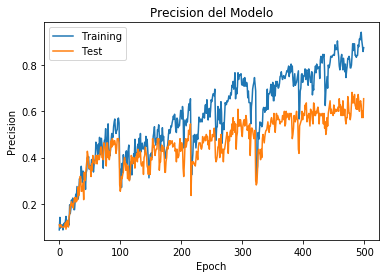

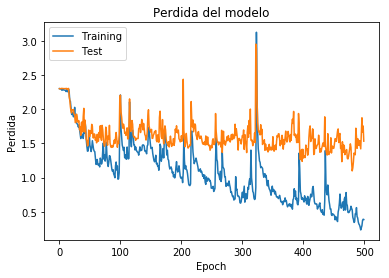

In [59]:
#plot_and_saving(LSTM2_1,'LSTM_2Layer2D6006')

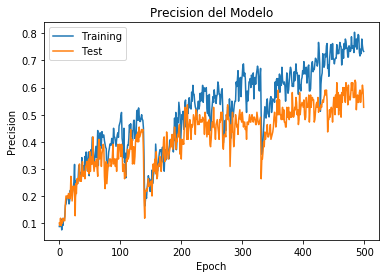

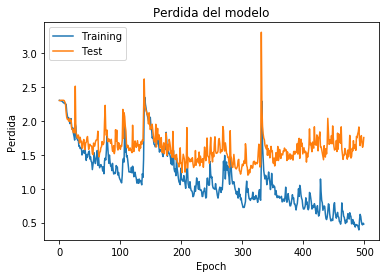

In [61]:
plot_and_saving(LSTM2_2,'LSTM_2Layer2D5007')

# Load Model 

En esta sección se cargará el modelo propuesto para realizar las pruebas

In [44]:
import tensorflow as tf
from keras.utils import plot_model

Using TensorFlow backend.


In [45]:
def load_model(dir):
    m=tf.keras.models.load_model(dir)
    return m